## Batch multi-armed bandit vs. A/B/n Testing

Visualization compares the posterior distributions of conversion rates after running a simulated test using multi-armed bandit optimization vs. an A/B/n test structure. Graph was used in a presentation about how multi-armed bandits (in particular batch updating via Thompson sampling) can allow us to better exploit superior creative for incremental revenue while still properly exploring the options to determine which is best.

In [2]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

# Set parameters
DAILY_IMPRESSIONS = 600000 # Total number of impressions served per day
NUM_DAYS = 3 # Length of test 
NUM_CREATIVE = 3 # Number of creatives in test
CONV_RT = .00034 # Conversion rate of best creative
CONV_DIFF = .00003 # Difference in conversion rates between creatives
np.random.seed(1004) # Seed for random number generation

def compute_probopt_num(y,n,ndraws=200000):
    """ Calculates the probability that each creative has the highest conversion rate
    Arguments:
        y: Array of number of converted impressions for each creative
        n: Array of number of unconverted impressions for each creative
        ndraws: Number of draws from each beta distribution for numeric integration
    Returns:
        ans: Array of probabilities
    """
    k=len(y)
    ans = np.zeros(k)
    betadraws = np.zeros([k,ndraws])
    for i in range(k):
        betadraws[i]=np.random.beta(y[i]+1,n[i]-y[i]+1,ndraws)
    for i in range(k):
        ans[i]=np.mean(np.argmax(betadraws,axis=0)==i)
    return ans

In [3]:
# True conversion rates for each creative
conv_rts = [CONV_RT - i * CONV_DIFF for i in range(NUM_CREATIVE)]

# Flat prior distributions for probability that each creative is best
probs_bandit = [np.array([1/NUM_CREATIVE]*NUM_CREATIVE)]
probs_ab = [np.array([1/NUM_CREATIVE]*NUM_CREATIVE)]

# Initialize bandit data and number of impressions per batch
data_bandit = [[]]*NUM_CREATIVE
imps_bandit = [[0]*NUM_CREATIVE]

# Simulate impression conversion data
data = np.random.rand(DAILY_IMPRESSIONS*NUM_DAYS,NUM_CREATIVE)<conv_rts

# Daily impressions per creative for A/B test
imps_ab = int(DAILY_IMPRESSIONS/NUM_CREATIVE)

# Generate impression results for bandit -- in Thompson sampling the distribution of next 
# day's impressions is same as probability that each creative is best
for d in range(NUM_DAYS):
    imps_bandit = np.concatenate((imps_bandit,[(DAILY_IMPRESSIONS*probs_bandit[-1]).astype('int')]))
    for c in range(NUM_CREATIVE):
        data_bandit[c] = np.concatenate([data_bandit[c], data[:imps_bandit[-1,c],c]])
    probs_bandit.append(compute_probopt_num([i.sum() for i in data_bandit], 
                                            [len(i) - i.sum() for i in data_bandit]))
    probs_ab.append(compute_probopt_num(data[:imps_ab*(d+1),:].sum(axis=0), 
                                        imps_ab*(d+1) - data[:imps_ab*(d+1),:].sum(axis=0)))

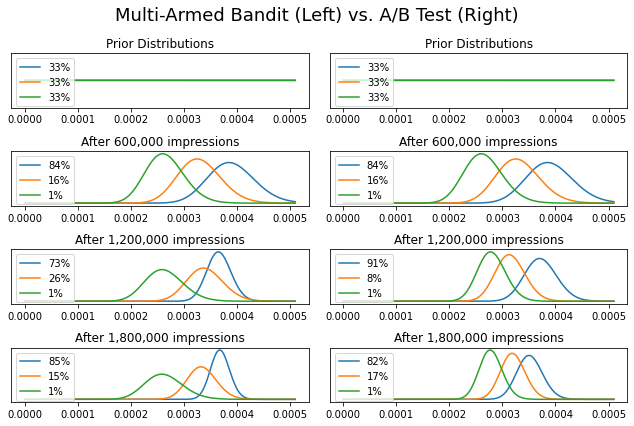

In [4]:
# Generate graph of posterior distributions after each day
titles = ['Prior Distributions'] + ["After {:,} impressions".format(DAILY_IMPRESSIONS * (i+1)) 
                                   for i in range(NUM_DAYS)]
x=np.linspace(0,CONV_RT*1.5,1000)
fig, axs = plt.subplots(NUM_DAYS+1, 2, figsize=(9,NUM_DAYS*2))
#rv =[]
for i in range(NUM_DAYS+1):
    plt.subplot(NUM_DAYS+1,2,i*2+1)
    for c in range(NUM_CREATIVE):
        rv = beta(data_bandit[c][:imps_bandit[:i+1,c].sum()+1].sum()+1,
                  imps_bandit[:i+1,c].sum() - data_bandit[c][:imps_bandit[:i+1,c].sum()+1].sum()+1)
        plt.plot(x,rv.pdf(x), label='{}%'.format(int(round(100*probs_bandit[i][c]))))
    plt.title(titles[i])
    plt.legend(loc='upper left')
    plt.subplot(NUM_DAYS+1,2,i*2+2)
    for c in range(NUM_CREATIVE):
        rv = beta(data[:imps_ab*i,c].sum()+1,
                  imps_ab*i - data[:imps_ab*i,c].sum()+1)
        plt.plot(x,rv.pdf(x), label='{}%'.format(int(round(100*probs_ab[i][c]))))
    plt.title(titles[i])
    plt.legend(loc='upper left')
plt.suptitle('Multi-Armed Bandit (Left) vs. A/B Test (Right)', fontsize=18)
[j.axes.yaxis.set_ticklabels([]) for i in axs for j in i]
[j.axes.yaxis.set_ticks([]) for i in axs for j in i]
plt.tight_layout()